In [ ]:
import csv
import time
from datasets import load_dataset
from openai import OpenAI
from typing import Tuple, Optional

client = OpenAI()  # uses OPENAI_API_KEY

MSC_PROMPT_TEMPLATE = """
You are a classifier. Your task is to assign the most relevant high-level
Mathematics Subject Classification (MSC) domain to the given question. You
must return only one domain.

Use the top-level MSC domains:
00 General and overarching topics; collections
01 History and biography
03 Mathematical logic and foundations
05 Combinatorics
06 Order, lattices, ordered algebraic structures
08 General algebraic systems
11 Number theory
12 Field theory and polynomials
13 Commutative algebra
14 Algebraic geometry
15 Linear and multilinear algebra; matrix theory
16 Associative rings and algebras
17 Nonassociative rings and algebras
18 Category theory; homological algebra
19 K-theory
20 Group theory and generalizations
22 Topological groups, Lie groups
26 Real functions
28 Measure and integration
30 Functions of a complex variable
31 Potential theory
32 Several complex variables and analytic spaces
33 Special functions
34 Ordinary differential equations
35 Partial differential equations
37 Dynamical systems and ergodic theory
39 Difference and functional equations
40 Sequences, series, summability
41 Approximations and expansions
42 Harmonic analysis on Euclidean spaces
43 Abstract harmonic analysis
44 Integral transforms, operational calculus
45 Integral equations
46 Functional analysis
47 Operator theory
49 Calculus of variations and optimal control; optimization
51 Geometry
52 Convex and discrete geometry
53 Differential geometry
54 General topology
55 Algebraic topology
57 Manifolds and cell complexes
58 Global analysis, analysis on manifolds
60 Probability theory and stochastic processes
62 Statistics
65 Numerical analysis
68 Computer science
70 Mechanics of particles and systems
74 Mechanics of deformable solids
76 Fluid mechanics
78 Optics, electromagnetic theory
80 Classical thermodynamics, heat transfer
81 Quantum theory
82 Statistical mechanics, structure of matter
83 Relativity and gravitational theory
85 Astronomy and astrophysics
86 Geophysics
90 Operations research, mathematical programming
91 Game theory, economics, social and behavioral sciences
92 Biology and other natural sciences
93 Systems theory; control
94 Information and communication, circuits
97 Mathematics education

Given a question, identify which MSC domain it belongs to. Consider the core
mathematical idea involved.

Return your answer in this exact format:
MSC code: <MSC code>
Domain: <Domain name>

Question:
{question}
"""


def parse_msc_response(text: str) -> Tuple[str, str]:
    """
    Parse the model output into (msc_code, domain).

    Expected format:
    MSC code: 51
    Domain: Geometry
    """
    msc_code = ""
    domain = ""

    for line in text.splitlines():
        line_stripped = line.strip()
        lower = line_stripped.lower()

        if lower.startswith("msc code"):
            # "MSC code: 51" -> "51"
            after_colon = line_stripped.split(":", 1)[1].strip()
            # take the first token in case the model adds extra words
            msc_code = after_colon.split()[0]
        elif lower.startswith("domain"):
            # "Domain: Geometry" -> "Geometry"
            domain = line_stripped.split(":", 1)[1].strip()

    return msc_code, domain


def classify_difficult_1k(
    model: str = "gpt-5-mini",
    dataset_name: str = "Dendiiiii/difficult-1k",
    split: str = "train",
    output_csv: str = "msc_labels_difficult1k.csv",
    sleep_seconds: float = 0.5,
    max_examples: Optional[int] = None,
) -> None:
    """
    Loop over the Hugging Face dataset and classify each problem
    into an MSC domain using the ChatGPT API.

    If max_examples is None, process the entire split.
    Otherwise, stop after max_examples examples.

    The CSV will have columns: index, example_id, msc_code, domain.
    """
    ds = load_dataset(dataset_name, split=split)

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["index", "example_id", "msc_code", "domain"])

        for idx, example in enumerate(ds):
            if max_examples is not None and idx >= max_examples:
                break

            # Adjust this key if your dataset uses a different name
            question = example["problem"]
            example_id = example.get("id", idx)

            user_prompt = MSC_PROMPT_TEMPLATE.format(question=question)

            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": (
                                "You are an expert classifier that assigns "
                                "top-level MSC domains to math problems."
                            ),
                        },
                        {"role": "user", "content": user_prompt},
                    ],
                )

                raw = response.choices[0].message.content.strip()
                msc_code, domain = parse_msc_response(raw)

                writer.writerow([idx, example_id, msc_code, domain])
                print(f"{idx}: id={example_id} -> {msc_code}, {domain}")

            except Exception as e:
                # Log empty values on error so row count still matches
                writer.writerow([idx, example_id, "", ""])
                print(f"Error on index {idx} (id={example_id}): {e}")

            time.sleep(sleep_seconds)


if __name__ == "__main__":
    # For the whole dataset, leave max_examples as None
    classify_difficult_1k(max_examples=None)
    # For testing only the first 10, you could call:
    # classify_difficult_1k(max_examples=10)

0: id=0 -> 51, Geometry
1: id=1 -> 51, Geometry
2: id=2 -> 51, Geometry
3: id=3 -> 51, Geometry
4: id=4 -> 51, Geometry
5: id=5 -> 51, Geometry
6: id=6 -> 51, Geometry
7: id=7 -> 97, Mathematics education
8: id=8 -> 51, Geometry
9: id=9 -> 51, Geometry
10: id=10 -> 51, Geometry
11: id=11 -> 51, Geometry
12: id=12 -> 62, Statistics
13: id=13 -> 05, Combinatorics
14: id=14 -> 00, General and overarching topics; collections
15: id=15 -> 51, Geometry
16: id=16 -> 51, Geometry
17: id=17 -> 51, Geometry
18: id=18 -> 51, Geometry
19: id=19 -> 51, Geometry
20: id=20 -> 51, Geometry
21: id=21 -> 51, Geometry
22: id=22 -> 51, Geometry
23: id=23 -> 86, Geophysics
24: id=24 -> 00, General and overarching topics; collections
25: id=25 -> 26, Real functions
26: id=26 -> 97, Mathematics education
27: id=27 -> 51, Geometry
28: id=28 -> 51, Geometry
29: id=29 -> 51, Geometry
30: id=30 -> 51, Geometry
31: id=31 -> 51, Geometry
32: id=32 -> 97, Mathematics education
33: id=33 -> 92, Biology and other nat

/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


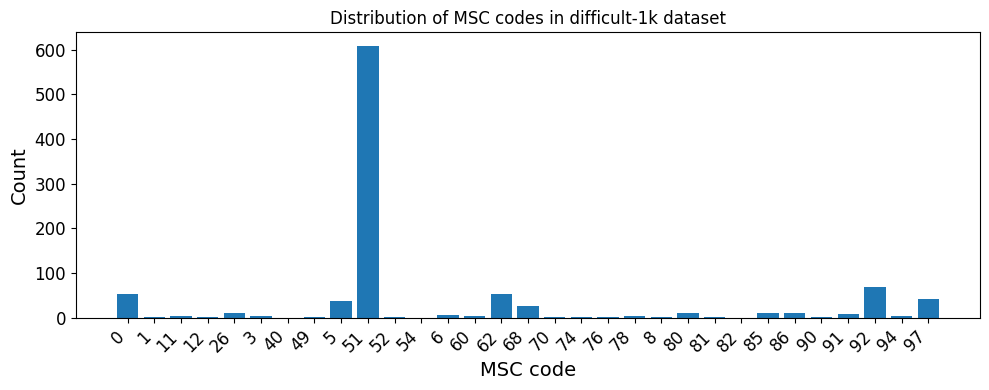

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with MSC labels
df = pd.read_excel("msc_labels_difficult1k.xlsx")

# Clean codes and drop empty ones
df["msc_code"] = df["msc_code"].astype(str).str.strip()
df_nonempty = df[df["msc_code"] != ""]

# Count each MSC code
counts = df_nonempty["msc_code"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
codes = counts.index.astype(str).tolist()
values = counts.values

plt.bar(codes, values)
plt.xlabel("MSC code", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of MSC codes in difficult-1k dataset")
plt.xticks(rotation=45, ha="right", fontsize=12)

# Tick size for axes
plt.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
# Save if you want to include in a paper
plt.savefig("msc_code_distribution_difficult1k_from_xlsx.pdf", dpi=800)
plt.show()


In [ ]:
import csv
import time
from datasets import load_dataset
from openai import OpenAI
from typing import Tuple, Optional

client = OpenAI()  # uses OPENAI_API_KEY

MSC_PROMPT_TEMPLATE = """
You are a classifier. Your task is to assign the most relevant high-level
Mathematics Subject Classification (MSC) domain to the given question. You
must return only one domain.

Use the top-level MSC domains:
00 General and overarching topics; collections
01 History and biography
03 Mathematical logic and foundations
05 Combinatorics
06 Order, lattices, ordered algebraic structures
08 General algebraic systems
11 Number theory
12 Field theory and polynomials
13 Commutative algebra
14 Algebraic geometry
15 Linear and multilinear algebra; matrix theory
16 Associative rings and algebras
17 Nonassociative rings and algebras
18 Category theory; homological algebra
19 K-theory
20 Group theory and generalizations
22 Topological groups, Lie groups
26 Real functions
28 Measure and integration
30 Functions of a complex variable
31 Potential theory
32 Several complex variables and analytic spaces
33 Special functions
34 Ordinary differential equations
35 Partial differential equations
37 Dynamical systems and ergodic theory
39 Difference and functional equations
40 Sequences, series, summability
41 Approximations and expansions
42 Harmonic analysis on Euclidean spaces
43 Abstract harmonic analysis
44 Integral transforms, operational calculus
45 Integral equations
46 Functional analysis
47 Operator theory
49 Calculus of variations and optimal control; optimization
51 Geometry
52 Convex and discrete geometry
53 Differential geometry
54 General topology
55 Algebraic topology
57 Manifolds and cell complexes
58 Global analysis, analysis on manifolds
60 Probability theory and stochastic processes
62 Statistics
65 Numerical analysis
68 Computer science
70 Mechanics of particles and systems
74 Mechanics of deformable solids
76 Fluid mechanics
78 Optics, electromagnetic theory
80 Classical thermodynamics, heat transfer
81 Quantum theory
82 Statistical mechanics, structure of matter
83 Relativity and gravitational theory
85 Astronomy and astrophysics
86 Geophysics
90 Operations research, mathematical programming
91 Game theory, economics, social and behavioral sciences
92 Biology and other natural sciences
93 Systems theory; control
94 Information and communication, circuits
97 Mathematics education

Given a question, identify which MSC domain it belongs to. Consider the core
mathematical idea involved.

Return your answer in this exact format:
MSC code: <MSC code>
Domain: <Domain name>

Question:
{question}
"""


def parse_msc_response(text: str) -> Tuple[str, str]:
    """
    Parse the model output into (msc_code, domain).

    Expected format:
    MSC code: 51
    Domain: Geometry
    """
    msc_code = ""
    domain = ""

    for line in text.splitlines():
        line_stripped = line.strip()
        lower = line_stripped.lower()

        if lower.startswith("msc code"):
            # "MSC code: 51" -> "51"
            after_colon = line_stripped.split(":", 1)[1].strip()
            # take the first token in case the model adds extra words
            msc_code = after_colon.split()[0]
        elif lower.startswith("domain"):
            # "Domain: Geometry" -> "Geometry"
            domain = line_stripped.split(":", 1)[1].strip()

    return msc_code, domain


def classify_difficult_1k(
    model: str = "gpt-5-mini",
    dataset_name: str = "Dendiiiii/random-1k",
    split: str = "train",
    output_csv: str = "msc_labels_random1k.csv",
    sleep_seconds: float = 0.5,
    max_examples: Optional[int] = None,
) -> None:
    """
    Loop over the Hugging Face dataset and classify each problem
    into an MSC domain using the ChatGPT API.

    If max_examples is None, process the entire split.
    Otherwise, stop after max_examples examples.

    The CSV will have columns: index, example_id, msc_code, domain.
    """
    ds = load_dataset(dataset_name, split=split)

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["index", "example_id", "msc_code", "domain"])

        for idx, example in enumerate(ds):
            if max_examples is not None and idx >= max_examples:
                break

            # Adjust this key if your dataset uses a different name
            question = example["problem"]
            example_id = example.get("id", idx)

            user_prompt = MSC_PROMPT_TEMPLATE.format(question=question)

            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": (
                                "You are an expert classifier that assigns "
                                "top-level MSC domains to math problems."
                            ),
                        },
                        {"role": "user", "content": user_prompt},
                    ],
                )

                raw = response.choices[0].message.content.strip()
                msc_code, domain = parse_msc_response(raw)

                writer.writerow([idx, example_id, msc_code, domain])
                print(f"{idx}: id={example_id} -> {msc_code}, {domain}")

            except Exception as e:
                # Log empty values on error so row count still matches
                writer.writerow([idx, example_id, "", ""])
                print(f"Error on index {idx} (id={example_id}): {e}")

            time.sleep(sleep_seconds)


if __name__ == "__main__":
    # For the whole dataset, leave max_examples as None
    classify_difficult_1k(max_examples=None)
    # For testing only the first 10, you could call:
    # classify_difficult_1k(max_examples=10)

0: id=0 -> 92, Biology and other natural sciences
1: id=1 -> 51, Geometry
2: id=2 -> 97, Mathematics education
3: id=3 -> 51, Geometry
4: id=4 -> 62, Statistics
5: id=5 -> 51, Geometry
6: id=6 -> 92, Biology and other natural sciences
7: id=7 -> 05, Combinatorics
8: id=8 -> 51, Geometry
9: id=9 -> 51, Geometry
10: id=10 -> 60, Probability theory and stochastic processes
11: id=11 -> 06, Order, lattices, ordered algebraic structures
12: id=12 -> 97, Mathematics education
13: id=13 -> 51, Geometry
14: id=14 -> 92, Biology and other natural sciences
15: id=15 -> 51, Geometry
16: id=16 -> 51, Geometry
17: id=17 -> 92, Biology and other natural sciences
18: id=18 -> 05, Combinatorics
19: id=19 -> 68, Computer science
20: id=20 -> 92, Biology and other natural sciences
21: id=21 -> 60, Probability theory and stochastic processes
22: id=22 -> 86, Geophysics
23: id=23 -> 68, Computer science
24: id=24 -> 51, Geometry
25: id=25 -> 92, Biology and other natural sciences
26: id=26 -> 97, Mathemat

/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


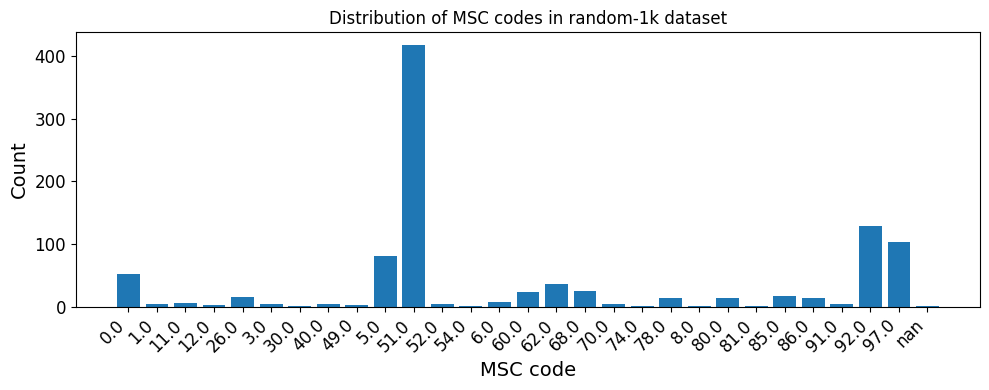

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with MSC labels
df = pd.read_excel("msc_labels_random1k.xlsx")

# Clean codes and drop empty ones
df["msc_code"] = df["msc_code"].astype(str).str.strip()
df_nonempty = df[df["msc_code"] != ""]

# Count each MSC code
counts = df_nonempty["msc_code"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
codes = counts.index.astype(str).tolist()
values = counts.values

plt.bar(codes, values)
plt.xlabel("MSC code", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of MSC codes in random-1k dataset")
plt.xticks(rotation=45, ha="right", fontsize=12)

# Tick size for axes
plt.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
# Save if you want to include in a paper
plt.savefig("msc_code_distribution_difficult1k_from_xlsx.pdf", dpi=800)
plt.show()


In [ ]:
import csv
import time
from datasets import load_dataset
from openai import OpenAI
from typing import Tuple, Optional

client = OpenAI()

MSC_PROMPT_TEMPLATE = """
You are a classifier. Your task is to assign the most relevant high-level
Mathematics Subject Classification (MSC) domain to the given question. You
must return only one domain.

Use the top-level MSC domains:
00 General and overarching topics; collections
01 History and biography
03 Mathematical logic and foundations
05 Combinatorics
06 Order, lattices, ordered algebraic structures
08 General algebraic systems
11 Number theory
12 Field theory and polynomials
13 Commutative algebra
14 Algebraic geometry
15 Linear and multilinear algebra; matrix theory
16 Associative rings and algebras
17 Nonassociative rings and algebras
18 Category theory; homological algebra
19 K-theory
20 Group theory and generalizations
22 Topological groups, Lie groups
26 Real functions
28 Measure and integration
30 Functions of a complex variable
31 Potential theory
32 Several complex variables and analytic spaces
33 Special functions
34 Ordinary differential equations
35 Partial differential equations
37 Dynamical systems and ergodic theory
39 Difference and functional equations
40 Sequences, series, summability
41 Approximations and expansions
42 Harmonic analysis on Euclidean spaces
43 Abstract harmonic analysis
44 Integral transforms, operational calculus
45 Integral equations
46 Functional analysis
47 Operator theory
49 Calculus of variations and optimal control; optimization
51 Geometry
52 Convex and discrete geometry
53 Differential geometry
54 General topology
55 Algebraic topology
57 Manifolds and cell complexes
58 Global analysis, analysis on manifolds
60 Probability theory and stochastic processes
62 Statistics
65 Numerical analysis
68 Computer science
70 Mechanics of particles and systems
74 Mechanics of deformable solids
76 Fluid mechanics
78 Optics, electromagnetic theory
80 Classical thermodynamics, heat transfer
81 Quantum theory
82 Statistical mechanics, structure of matter
83 Relativity and gravitational theory
85 Astronomy and astrophysics
86 Geophysics
90 Operations research, mathematical programming
91 Game theory, economics, social and behavioral sciences
92 Biology and other natural sciences
93 Systems theory; control
94 Information and communication, circuits
97 Mathematics education
98 None of above

Given a question, identify which MSC domain it belongs to. Consider the core
mathematical idea involved.

Return your answer in this exact format:
MSC code: <MSC code>
Domain: <Domain name>

Question:
{question}
"""


def parse_msc_response(text: str) -> Tuple[str, str]:
    """
    Parse the model output into (msc_code, domain).

    Expected format:
    MSC code: 51
    Domain: Geometry
    """
    msc_code = ""
    domain = ""

    for line in text.splitlines():
        line_stripped = line.strip()
        lower = line_stripped.lower()

        if lower.startswith("msc code"):
            # "MSC code: 51" -> "51"
            after_colon = line_stripped.split(":", 1)[1].strip()
            # take the first token in case the model adds extra words
            msc_code = after_colon.split()[0]
        elif lower.startswith("domain"):
            # "Domain: Geometry" -> "Geometry"
            domain = line_stripped.split(":", 1)[1].strip()

    return msc_code, domain


def classify_difficult_1k(
    model: str = "gpt-5-mini",
    dataset_name: str = "WaltonFuture/Multimodal-Cold-Start",
    split: str = "train",
    output_csv: str = "msc_labels_all51k.csv",
    sleep_seconds: float = 0.5,
    max_examples: Optional[int] = None,
) -> None:
    """
    Loop over the Hugging Face dataset and classify each problem
    into an MSC domain using the ChatGPT API.

    If max_examples is None, process the entire split.
    Otherwise, stop after max_examples examples.

    The CSV will have columns: index, example_id, msc_code, domain.
    """
    ds = load_dataset(dataset_name, split=split)

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["index", "example_id", "msc_code", "domain"])

        for idx, example in enumerate(ds):
            if max_examples is not None and idx >= max_examples:
                break

            # Adjust this key if your dataset uses a different name
            question = example["problem"]
            example_id = example.get("id", idx)

            user_prompt = MSC_PROMPT_TEMPLATE.format(question=question)

            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": (
                                "You are an expert classifier that assigns "
                                "top-level MSC domains to math problems."
                            ),
                        },
                        {"role": "user", "content": user_prompt},
                    ],
                )

                raw = response.choices[0].message.content.strip()
                msc_code, domain = parse_msc_response(raw)

                writer.writerow([idx, example_id, msc_code, domain])
                print(f"{idx}: id={example_id} -> {msc_code}, {domain}")

            except Exception as e:
                # Log empty values on error so row count still matches
                writer.writerow([idx, example_id, "", ""])
                print(f"Error on index {idx} (id={example_id}): {e}")

            time.sleep(sleep_seconds)


if __name__ == "__main__":
    # For the whole dataset, leave max_examples as None
    classify_difficult_1k(max_examples=None)

/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 51534/51534 [00:01<00:00, 35759.75 examples/s]


0: id=0 -> 51, Geometry
1: id=1 -> 51, Geometry
2: id=2 -> 51, Geometry
3: id=3 -> 51, Geometry
4: id=4 -> 51, Geometry
5: id=5 -> 12, Field theory and polynomials
6: id=6 -> 51, Geometry
7: id=7 -> 51, Geometry
8: id=8 -> 51, Geometry
9: id=9 -> 51, Geometry
10: id=10 -> 51, Geometry
11: id=11 -> 51, Geometry
12: id=12 -> 97, Mathematics education
13: id=13 -> 51, Geometry
14: id=14 -> 11, Number theory
15: id=15 -> 51, Geometry
16: id=16 -> 51, Geometry
17: id=17 -> 51, Geometry
18: id=18 -> 51, Geometry
19: id=19 -> 51, Geometry
20: id=20 -> 51, Geometry
21: id=21 -> 51, Geometry
22: id=22 -> 51, Geometry
23: id=23 -> 51, Geometry
24: id=24 -> 51, Geometry
25: id=25 -> 51, Geometry
26: id=26 -> 51, Geometry
27: id=27 -> 51, Geometry
28: id=28 -> 51, Geometry
29: id=29 -> 51, Geometry
30: id=30 -> 51, Geometry
31: id=31 -> 51, Geometry
32: id=32 -> 51, Geometry
33: id=33 -> 51, Geometry
34: id=34 -> 51, Geometry
35: id=35 -> 97, Mathematics education
36: id=36 -> 51, Geometry
37: id=

In [ ]:
import csv
import time
from datasets import load_dataset
from openai import OpenAI
from typing import Tuple, Optional

client = OpenAI()  # uses OPENAI_API_KEY

MSC_PROMPT_TEMPLATE = """
You are a classifier. Your task is to assign the most relevant high-level
Mathematics Subject Classification (MSC) domain to the given question. You
must return only one domain.

Use the top-level MSC domains:
00 General and overarching topics; collections
01 History and biography
03 Mathematical logic and foundations
05 Combinatorics
06 Order, lattices, ordered algebraic structures
08 General algebraic systems
11 Number theory
12 Field theory and polynomials
13 Commutative algebra
14 Algebraic geometry
15 Linear and multilinear algebra; matrix theory
16 Associative rings and algebras
17 Nonassociative rings and algebras
18 Category theory; homological algebra
19 K-theory
20 Group theory and generalizations
22 Topological groups, Lie groups
26 Real functions
28 Measure and integration
30 Functions of a complex variable
31 Potential theory
32 Several complex variables and analytic spaces
33 Special functions
34 Ordinary differential equations
35 Partial differential equations
37 Dynamical systems and ergodic theory
39 Difference and functional equations
40 Sequences, series, summability
41 Approximations and expansions
42 Harmonic analysis on Euclidean spaces
43 Abstract harmonic analysis
44 Integral transforms, operational calculus
45 Integral equations
46 Functional analysis
47 Operator theory
49 Calculus of variations and optimal control; optimization
51 Geometry
52 Convex and discrete geometry
53 Differential geometry
54 General topology
55 Algebraic topology
57 Manifolds and cell complexes
58 Global analysis, analysis on manifolds
60 Probability theory and stochastic processes
62 Statistics
65 Numerical analysis
68 Computer science
70 Mechanics of particles and systems
74 Mechanics of deformable solids
76 Fluid mechanics
78 Optics, electromagnetic theory
80 Classical thermodynamics, heat transfer
81 Quantum theory
82 Statistical mechanics, structure of matter
83 Relativity and gravitational theory
85 Astronomy and astrophysics
86 Geophysics
90 Operations research, mathematical programming
91 Game theory, economics, social and behavioral sciences
92 Biology and other natural sciences
93 Systems theory; control
94 Information and communication, circuits
97 Mathematics education
98 None of above

Given a question, identify which MSC domain it belongs to. Consider the core
mathematical idea involved.

Return your answer in this exact format:
MSC code: <MSC code>
Domain: <Domain name>

Question:
{question}
"""


def parse_msc_response(text: str) -> Tuple[str, str]:
    """
    Parse the model output into (msc_code, domain).

    Expected format:
    MSC code: 51
    Domain: Geometry
    """
    msc_code = ""
    domain = ""

    for line in text.splitlines():
        line_stripped = line.strip()
        lower = line_stripped.lower()

        if lower.startswith("msc code"):
            # "MSC code: 51" -> "51"
            after_colon = line_stripped.split(":", 1)[1].strip()
            # take the first token in case the model adds extra words
            msc_code = after_colon.split()[0]
        elif lower.startswith("domain"):
            # "Domain: Geometry" -> "Geometry"
            domain = line_stripped.split(":", 1)[1].strip()

    return msc_code, domain


def classify_difficult_1k(
    model: str = "gpt-5-mini",
    dataset_name: str = "WaltonFuture/Multimodal-Cold-Start",
    split: str = "train",
    output_csv: str = "msc_labels_all51k.csv",
    sleep_seconds: float = 0.5,
    max_examples: Optional[int] = None,
    start_idx: int = 0,  # new
) -> None:
    ds = load_dataset(dataset_name, split=split)

    # If starting from 0, create a new file with header
    # If resuming, append and do not rewrite header
    mode = "a" if start_idx > 0 else "w"

    with open(output_csv, mode, newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        if start_idx == 0:
            writer.writerow(["index", "example_id", "msc_code", "domain"])

        # Loop from start_idx instead of from 0
        for idx in range(start_idx, len(ds)):
            if max_examples is not None and idx >= start_idx + max_examples:
                break

            example = ds[idx]
            question = example["problem"]
            example_id = example.get("id", idx)

            user_prompt = MSC_PROMPT_TEMPLATE.format(question=question)

            try:
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": (
                                "You are an expert classifier that assigns "
                                "top-level MSC domains to math problems."
                            ),
                        },
                        {"role": "user", "content": user_prompt},
                    ],
                )

                raw = response.choices[0].message.content.strip()
                msc_code, domain = parse_msc_response(raw)

                writer.writerow([idx, example_id, msc_code, domain])
                print(f"{idx}: id={example_id} -> {msc_code}, {domain}")

            except Exception as e:
                writer.writerow([idx, example_id, "", ""])
                print(f"Error on index {idx} (id={example_id}): {e}")

            time.sleep(sleep_seconds)


if __name__ == "__main__":
    classify_difficult_1k(
        max_examples=None,
        start_idx=18999,  # resume here
    )


/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


18999: id=18999 -> 51, Geometry
19000: id=19000 -> 51, Geometry
19001: id=19001 -> 51, Geometry
19002: id=19002 -> 51, Geometry
19003: id=19003 -> 51, Geometry
19004: id=19004 -> 51, Geometry
19005: id=19005 -> 51, Geometry
19006: id=19006 -> 51, Geometry
19007: id=19007 -> 51, Geometry
19008: id=19008 -> 51, Geometry
19009: id=19009 -> 51, Geometry
19010: id=19010 -> 51, Geometry
19011: id=19011 -> 51, Geometry
19012: id=19012 -> 51, Geometry
19013: id=19013 -> 51, Geometry
19014: id=19014 -> 51, Geometry
19015: id=19015 -> 51, Geometry
19016: id=19016 -> 51, Geometry
19017: id=19017 -> 51, Geometry
19018: id=19018 -> 51, Geometry
19019: id=19019 -> 51, Geometry
19020: id=19020 -> 51, Geometry
19021: id=19021 -> 51, Geometry
19022: id=19022 -> 51, Geometry
19023: id=19023 -> 51, Geometry
19024: id=19024 -> 51, Geometry
19025: id=19025 -> 51, Geometry
19026: id=19026 -> 51, Geometry
19027: id=19027 -> 51, Geometry
19028: id=19028 -> 51, Geometry
19029: id=19029 -> 51, Geometry
19030: i

/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


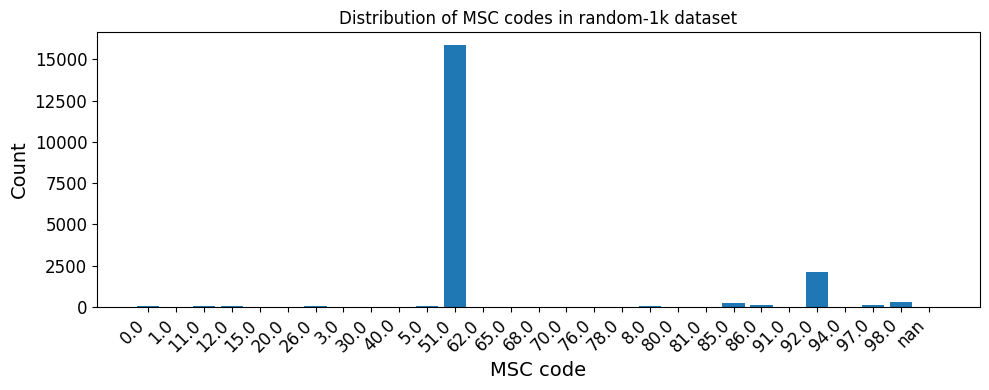

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with MSC labels
df = pd.read_excel("msc_labels_all51k_1.xlsx")

# Clean codes and drop empty ones
df["msc_code"] = df["msc_code"].astype(str).str.strip()
df_nonempty = df[df["msc_code"] != ""]

# Count each MSC code
counts = df_nonempty["msc_code"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
codes = counts.index.astype(str).tolist()
values = counts.values

plt.bar(codes, values)
plt.xlabel("MSC code", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of MSC codes in random-1k dataset")
plt.xticks(rotation=45, ha="right", fontsize=12)

# Tick size for axes
plt.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
# Save if you want to include in a paper
plt.savefig("msc_code_distribution_difficult1k_from_xlsx.pdf", dpi=800)
plt.show()


/home/yizhu/Production/anaconda3/envs/timbrewatermark/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


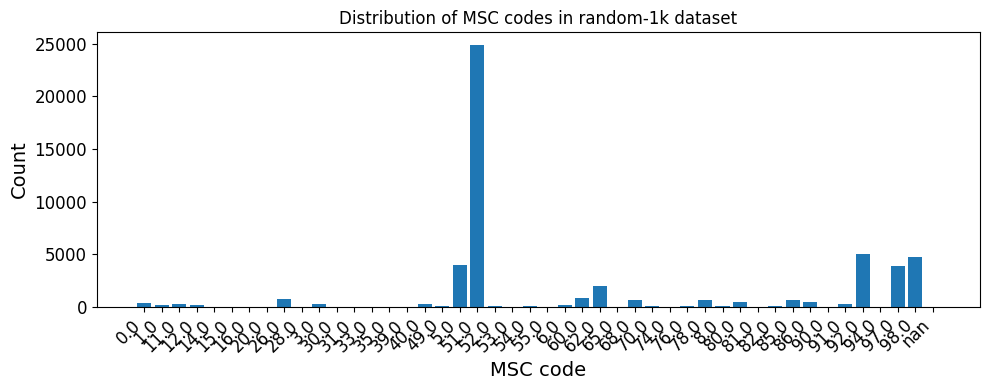

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with MSC labels
df = pd.read_excel("msc_labels_all51k_2.xlsx")

# Clean codes and drop empty ones
df["msc_code"] = df["msc_code"].astype(str).str.strip()
df_nonempty = df[df["msc_code"] != ""]

# Count each MSC code
counts = df_nonempty["msc_code"].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 4))
codes = counts.index.astype(str).tolist()
values = counts.values

plt.bar(codes, values)
plt.xlabel("MSC code", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Distribution of MSC codes in random-1k dataset")
plt.xticks(rotation=45, ha="right", fontsize=12)

# Tick size for axes
plt.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
# Save if you want to include in a paper
plt.savefig("msc_code_distribution_difficult1k_from_xlsx.pdf", dpi=800)
plt.show()
